In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
# @title Imports
from dataclasses import dataclass
import datetime, pytz
import enum
import functools
import os
import os
import time
from typing import Final, Sequence
from typing import Optional
from typing import Union, cast
os.environ['WRAPT_DISABLE_EXTENSIONS'] = 'true'

from absl import logging
import gin
import gin
from matplotlib import patches
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import pandas as pd
import reverb
import mediapy as media
from IPython.display import clear_output
from smart_control.environment import environment
from smart_control.proto import smart_control_building_pb2
from smart_control.proto import smart_control_normalization_pb2
from smart_control.reward import electricity_energy_cost
from smart_control.reward import natural_gas_energy_cost
from smart_control.reward import setpoint_energy_carbon_regret
from smart_control.reward import setpoint_energy_carbon_reward
from smart_control.simulator import randomized_arrival_departure_occupancy
from smart_control.simulator import rejection_simulator_building
from smart_control.simulator import simulator_building
from smart_control.simulator import step_function_occupancy
from smart_control.simulator import stochastic_convection_simulator
from smart_control.utils import bounded_action_normalizer
from smart_control.utils import building_renderer
from smart_control.utils import controller_reader
from smart_control.utils import controller_writer
from smart_control.utils import conversion_utils
from smart_control.utils import observation_normalizer
from smart_control.utils import reader_lib
from smart_control.utils import writer_lib
from smart_control.utils import histogram_reducer
from smart_control.utils import environment_utils
import tensorflow as tf
# from tf_agents.agents.sac import sac_agent
from tf_agents.agents.ppo import ppo_agent
from tf_agents.agents.ppo import ppo_actor_network
from tf_agents.environments import parallel_py_environment
from tf_agents.environments import tf_py_environment
from tf_agents.networks import value_network
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver
from tf_agents.drivers.dynamic_episode_driver import DynamicEpisodeDriver
# from tf_agents.agents.sac import tanh_normal_projection_network
from tf_agents.drivers import py_driver
from tf_agents.keras_layers import inner_reshape
from tf_agents.metrics import py_metrics
from tf_agents.networks import nest_map
from tf_agents.networks import sequential
from tf_agents.policies import greedy_policy
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_py_policy
from tf_agents.policies import tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.specs import tensor_spec
from tf_agents.train import actor
from tf_agents.train import learner
from tf_agents.train import triggers
from tf_agents.train.utils import spec_utils
from tf_agents.train.utils import train_utils
from tf_agents.trajectories import policy_step
from tf_agents.trajectories import time_step as ts
from tf_agents.trajectories import trajectory as trajectory_lib
from tf_agents.trajectories import trajectory
from tf_agents.typing import types

import tf_agents
# Enable interactive mode for multiprocessing in Jupyter notebooks
tf_agents.system.multiprocessing.enable_interactive_mode()

2024-10-06 23:39:09.022195: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-06 23:39:09.023398: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-06 23:39:09.041719: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-06 23:39:09.041737: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-06 23:39:09.042303: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [3]:
# @title Set local runtime configurations


def logging_info(*args):
  logging.info(*args)
  print(*args)

data_path = "/home/derek/sbsim/smart_control/configs/resources/sb1/" #@param {type:"string"}
metrics_path = "/home/derek/sbsim/metrics/" #@param {type:"string"}
output_data_path = '/home/derek/sbsim/smart_control/PPO/' #@param {type:"string"}
root_dir = "/home/derek/sbsim/" #@param {type:"string"}


# 
@gin.configurable
def get_histogram_reducer():


    reader = controller_reader.ProtoReader(data_path)

    hr = histogram_reducer.HistogramReducer(
        histogram_parameters_tuples=histogram_parameters_tuples,
        reader=reader,
        normalize_reduce=True,
        )
    return hr

!mkdir -p $root_dir
!mkdir -p $output_data_path
!mkdir -p $metrics_path




def remap_filepath(filepath) -> str:
    return filepath


In [4]:
# @title Plotting Utities
reward_shift = 0
reward_scale = 1.0
person_productivity_hour = 300.0

KELVIN_TO_CELSIUS = 273.15


def render_env(env: environment.Environment):
  """Renders the environment."""
  building_layout = env.building._simulator._building._floor_plan

  # create a renderer
  renderer = building_renderer.BuildingRenderer(building_layout, 1)

  # get the current temps to render
  # this also is not ideal, since the temps are not fully exposed.
  # V Ideally this should be a publicly accessable field
  temps = env.building._simulator._building.temp

  input_q = env.building._simulator._building.input_q

  # render
  vmin = 285
  vmax = 305
  image = renderer.render(
      temps,
      cmap='bwr',
      vmin=vmin,
      vmax=vmax,
      colorbar=False,
      input_q=input_q,
      diff_range=0.5,
      diff_size=1,
  ).convert('RGB')
  media.show_image(
      image, title='Environment %s' % env.current_simulation_timestamp
  )


def get_energy_timeseries(reward_infos, time_zone: str) -> pd.DataFrame:
  """Returns a timeseries of energy rates."""

  start_times = []
  end_times = []

  device_ids = []
  device_types = []
  air_handler_blower_electrical_energy_rates = []
  air_handler_air_conditioner_energy_rates = []
  boiler_natural_gas_heating_energy_rates = []
  boiler_pump_electrical_energy_rates = []

  for reward_info in reward_infos:
    end_timestamp = conversion_utils.proto_to_pandas_timestamp(
        reward_info.end_timestamp
    ).tz_convert(time_zone)
    start_timestamp = end_timestamp - pd.Timedelta(300, unit='second')

    for air_handler_id in reward_info.air_handler_reward_infos:
      start_times.append(start_timestamp)
      end_times.append(end_timestamp)

      device_ids.append(air_handler_id)
      device_types.append('air_handler')

      air_handler_blower_electrical_energy_rates.append(
          reward_info.air_handler_reward_infos[
              air_handler_id
          ].blower_electrical_energy_rate
      )
      air_handler_air_conditioner_energy_rates.append(
          reward_info.air_handler_reward_infos[
              air_handler_id
          ].air_conditioning_electrical_energy_rate
      )
      boiler_natural_gas_heating_energy_rates.append(0)
      boiler_pump_electrical_energy_rates.append(0)

    for boiler_id in reward_info.boiler_reward_infos:
      start_times.append(start_timestamp)
      end_times.append(end_timestamp)

      device_ids.append(boiler_id)
      device_types.append('boiler')

      air_handler_blower_electrical_energy_rates.append(0)
      air_handler_air_conditioner_energy_rates.append(0)

      boiler_natural_gas_heating_energy_rates.append(
          reward_info.boiler_reward_infos[
              boiler_id
          ].natural_gas_heating_energy_rate
      )
      boiler_pump_electrical_energy_rates.append(
          reward_info.boiler_reward_infos[boiler_id].pump_electrical_energy_rate
      )

  df_map = {
      'start_time': start_times,
      'end_time': end_times,
      'device_id': device_ids,
      'device_type': device_types,
      'air_handler_blower_electrical_energy_rate': (
          air_handler_blower_electrical_energy_rates
      ),
      'air_handler_air_conditioner_energy_rate': (
          air_handler_air_conditioner_energy_rates
      ),
      'boiler_natural_gas_heating_energy_rate': (
          boiler_natural_gas_heating_energy_rates
      ),
      'boiler_pump_electrical_energy_rate': boiler_pump_electrical_energy_rates,
  }
  df = pd.DataFrame(df_map).sort_values('start_time')
  return df


def get_outside_air_temperature_timeseries(
    observation_responses,
    time_zone: str,
) -> pd.Series:
  """Returns a timeseries of outside air temperature."""
  temps = []
  for i in range(len(observation_responses)):
    temp = [
        (
            conversion_utils.proto_to_pandas_timestamp(
                sor.timestamp
            ).tz_convert(time_zone)
            - pd.Timedelta(300, unit='second'),
            sor.continuous_value,
        )
        for sor in observation_responses[i].single_observation_responses
        if sor.single_observation_request.measurement_name
        == 'outside_air_temperature_sensor'
    ][0]
    temps.append(temp)

  res = list(zip(*temps))
  return pd.Series(res[1], index=res[0]).sort_index()


def get_reward_timeseries(
    reward_infos,
    reward_responses,
    time_zone: str,
) -> pd.DataFrame:
  """Returns a timeseries of reward values."""
  cols = [
      'agent_reward_value',
      'electricity_energy_cost',
      'carbon_emitted',
      'occupancy',
  ]
  df = pd.DataFrame(columns=cols)

  for i in range(min(len(reward_responses), len(reward_infos))):
    step_start_timestamp = conversion_utils.proto_to_pandas_timestamp(
        reward_infos[i].start_timestamp
    ).tz_convert(time_zone)
    step_end_timestamp = conversion_utils.proto_to_pandas_timestamp(
        reward_infos[i].end_timestamp
    ).tz_convert(time_zone)
    delta_time_sec = (step_end_timestamp - step_start_timestamp).total_seconds()
    occupancy = np.sum([
        reward_infos[i].zone_reward_infos[zone_id].average_occupancy
        for zone_id in reward_infos[i].zone_reward_infos
    ])

    df.loc[
        conversion_utils.proto_to_pandas_timestamp(
            reward_infos[i].start_timestamp
        ).tz_convert(time_zone)
    ] = [
        reward_responses[i].agent_reward_value,
        reward_responses[i].electricity_energy_cost,
        reward_responses[i].carbon_emitted,
        occupancy,
    ]

  df = df.sort_index()
  df['cumulative_reward'] = df['agent_reward_value'].cumsum()
  logging_info('Cumulative reward: %4.2f' % df.iloc[-1]['cumulative_reward'])
  return df


def format_plot(
    ax1, xlabel: str, start_time: int, end_time: int, time_zone: str
):
  """Formats a plot with common attributes."""
  ax1.set_facecolor('black')
  ax1.xaxis.tick_top()
  ax1.tick_params(axis='x', labelsize=12)
  ax1.tick_params(axis='y', labelsize=12)
  ax1.xaxis.set_major_formatter(
      mdates.DateFormatter('%a %m/%d %H:%M', tz=pytz.timezone(time_zone))
  )
  ax1.grid(color='gray', linestyle='-', linewidth=1.0)
  ax1.set_ylabel(xlabel, color='blue', fontsize=12)
  ax1.set_xlim(left=start_time, right=end_time)
  ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
  ax1.legend(prop={'size': 10})


def plot_occupancy_timeline(
    ax1, reward_timeseries: pd.DataFrame, time_zone: str
):
  local_times = [ts.tz_convert(time_zone) for ts in reward_timeseries.index]
  ax1.plot(
      local_times,
      reward_timeseries['occupancy'],
      color='cyan',
      marker=None,
      alpha=1,
      lw=2,
      linestyle='-',
      label='Num Occupants',
  )
  format_plot(
      ax1,
      'Occupancy',
      reward_timeseries.index.min(),
      reward_timeseries.index.max(),
      time_zone,
  )


def plot_energy_cost_timeline(
    ax1,
    reward_timeseries: pd.DataFrame,
    time_zone: str,
    cumulative: bool = False,
):
  local_times = [ts.tz_convert(time_zone) for ts in reward_timeseries.index]
  if cumulative:
    feature_timeseries_cost = reward_timeseries[
        'electricity_energy_cost'
    ].cumsum()
  else:
    feature_timeseries_cost = reward_timeseries['electricity_energy_cost']
  ax1.plot(
      local_times,
      feature_timeseries_cost,
      color='magenta',
      marker=None,
      alpha=1,
      lw=2,
      linestyle='-',
      label='Electricity',
  )

  format_plot(
      ax1,
      'Energy Cost [$]',
      reward_timeseries.index.min(),
      reward_timeseries.index.max(),
      time_zone,
  )


def plot_reward_timeline(ax1, reward_timeseries, time_zone):

  local_times = [ts.tz_convert(time_zone) for ts in reward_timeseries.index]

  ax1.plot(
      local_times,
      reward_timeseries['cumulative_reward'],
      color='royalblue',
      marker=None,
      alpha=1,
      lw=6,
      linestyle='-',
      label='reward',
  )
  format_plot(
      ax1,
      'Agent Reward',
      reward_timeseries.index.min(),
      reward_timeseries.index.max(),
      time_zone,
  )


def plot_energy_timeline(ax1, energy_timeseries, time_zone, cumulative=False):

  def _to_kwh(
      energy_rate: float,
      step_interval: pd.Timedelta = pd.Timedelta(5, unit='minute'),
  ) -> float:
    kw_power = energy_rate / 1000.0
    hwh_power = kw_power * step_interval / pd.Timedelta(1, unit='hour')
    return hwh_power.cumsum()

  timeseries = energy_timeseries[
      energy_timeseries['device_type'] == 'air_handler'
  ]

  if cumulative:
    feature_timeseries_ac = _to_kwh(
        timeseries['air_handler_air_conditioner_energy_rate']
    )
    feature_timeseries_blower = _to_kwh(
        timeseries['air_handler_blower_electrical_energy_rate']
    )
  else:
    feature_timeseries_ac = (
        timeseries['air_handler_air_conditioner_energy_rate'] / 1000.0
    )
    feature_timeseries_blower = (
        timeseries['air_handler_blower_electrical_energy_rate'] / 1000.0
    )

  ax1.plot(
      timeseries['start_time'],
      feature_timeseries_ac,
      color='magenta',
      marker=None,
      alpha=1,
      lw=4,
      linestyle='-',
      label='AHU Electricity',
  )
  ax1.plot(
      timeseries['start_time'],
      feature_timeseries_blower,
      color='magenta',
      marker=None,
      alpha=1,
      lw=4,
      linestyle='--',
      label='FAN Electricity',
  )

  timeseries = energy_timeseries[energy_timeseries['device_type'] == 'boiler']
  if cumulative:
    feature_timeseries_gas = _to_kwh(
        timeseries['boiler_natural_gas_heating_energy_rate']
    )
    feature_timeseries_pump = _to_kwh(
        timeseries['boiler_pump_electrical_energy_rate']
    )
  else:
    feature_timeseries_gas = (
        timeseries['boiler_natural_gas_heating_energy_rate'] / 1000.0
    )
    feature_timeseries_pump = (
        timeseries['boiler_pump_electrical_energy_rate'] / 1000.0
    )

  ax1.plot(
      timeseries['start_time'],
      feature_timeseries_gas,
      color='lime',
      marker=None,
      alpha=1,
      lw=4,
      linestyle='-',
      label='BLR Gas',
  )
  ax1.plot(
      timeseries['start_time'],
      feature_timeseries_pump,
      color='lime',
      marker=None,
      alpha=1,
      lw=4,
      linestyle='--',
      label='Pump Electricity',
  )

  if cumulative:
    label = 'HVAC Energy Consumption [kWh]'
  else:
    label = 'HVAC Power Consumption [kW]'

  format_plot(
      ax1,
      label,
      timeseries['start_time'].min(),
      timeseries['end_time'].max(),
      time_zone,
  )


def plot_carbon_timeline(ax1, reward_timeseries, time_zone, cumulative=False):
  """Plots carbon-emission timeline."""

  if cumulative:
    feature_timeseries_carbon = reward_timeseries['carbon_emitted'].cumsum()
  else:
    feature_timeseries_carbon = reward_timeseries['carbon_emitted']
  ax1.plot(
      reward_timeseries.index,
      feature_timeseries_carbon,
      color='white',
      marker=None,
      alpha=1,
      lw=4,
      linestyle='-',
      label='Carbon',
  )
  format_plot(
      ax1,
      'Carbon emission [kg]',
      reward_timeseries.index.min(),
      reward_timeseries.index.max(),
      time_zone,
  )


def get_zone_timeseries(reward_infos, time_zone):
  """Converts reward infos to a timeseries dataframe."""

  start_times = []
  end_times = []
  zones = []
  heating_setpoints = []
  cooling_setpoints = []
  zone_air_temperatures = []
  air_flow_rate_setpoints = []
  air_flow_rates = []
  average_occupancies = []

  for reward_info in reward_infos:
    start_timestamp = conversion_utils.proto_to_pandas_timestamp(
        reward_info.end_timestamp
    ).tz_convert(time_zone) - pd.Timedelta(300, unit='second')
    end_timestamp = conversion_utils.proto_to_pandas_timestamp(
        reward_info.end_timestamp
    ).tz_convert(time_zone)

    for zone_id in reward_info.zone_reward_infos:
      zones.append(zone_id)
      start_times.append(start_timestamp)
      end_times.append(end_timestamp)

      heating_setpoints.append(
          reward_info.zone_reward_infos[zone_id].heating_setpoint_temperature
      )
      cooling_setpoints.append(
          reward_info.zone_reward_infos[zone_id].cooling_setpoint_temperature
      )

      zone_air_temperatures.append(
          reward_info.zone_reward_infos[zone_id].zone_air_temperature
      )
      air_flow_rate_setpoints.append(
          reward_info.zone_reward_infos[zone_id].air_flow_rate_setpoint
      )
      air_flow_rates.append(
          reward_info.zone_reward_infos[zone_id].air_flow_rate
      )
      average_occupancies.append(
          reward_info.zone_reward_infos[zone_id].average_occupancy
      )

  df_map = {
      'start_time': start_times,
      'end_time': end_times,
      'zone': zones,
      'heating_setpoint_temperature': heating_setpoints,
      'cooling_setpoint_temperature': cooling_setpoints,
      'zone_air_temperature': zone_air_temperatures,
      'air_flow_rate_setpoint': air_flow_rate_setpoints,
      'air_flow_rate': air_flow_rates,
      'average_occupancy': average_occupancies,
  }
  return pd.DataFrame(df_map).sort_values('start_time')


def get_action_timeseries(action_responses):
  """Converts action responses to a dataframe."""
  timestamps = []
  device_ids = []
  setpoint_names = []
  setpoint_values = []
  response_types = []
  for action_response in action_responses:

    timestamp = conversion_utils.proto_to_pandas_timestamp(
        action_response.timestamp
    )
    for single_action_response in action_response.single_action_responses:
      device_id = single_action_response.request.device_id
      setpoint_name = single_action_response.request.setpoint_name
      setpoint_value = single_action_response.request.continuous_value
      response_type = single_action_response.response_type

      timestamps.append(timestamp)
      device_ids.append(device_id)
      setpoint_names.append(setpoint_name)
      setpoint_values.append(setpoint_value)
      response_types.append(response_type)

  return pd.DataFrame({
      'timestamp': timestamps,
      'device_id': device_ids,
      'setpoint_name': setpoint_names,
      'setpoint_value': setpoint_values,
      'response_type': response_types,
  })


def plot_action_timeline(ax1, action_timeseries, action_tuple, time_zone):
  """Plots action timeline."""

  single_action_timeseries = action_timeseries[
      (action_timeseries['device_id'] == action_tuple[0])
      & (action_timeseries['setpoint_name'] == action_tuple[1])
  ]
  single_action_timeseries = single_action_timeseries.sort_values(
      by='timestamp'
  )

  if action_tuple[1] in [
      'supply_water_setpoint',
      'supply_air_heating_temperature_setpoint',
  ]:
    single_action_timeseries['setpoint_value'] = (
        single_action_timeseries['setpoint_value'] - KELVIN_TO_CELSIUS
    )

  ax1.plot(
      single_action_timeseries['timestamp'],
      single_action_timeseries['setpoint_value'],
      color='lime',
      marker=None,
      alpha=1,
      lw=4,
      linestyle='-',
      label=action_tuple[1],
  )
  title = '%s %s' % (action_tuple[0], action_tuple[1])
  format_plot(
      ax1,
      'Action',
      single_action_timeseries['timestamp'].min(),
      single_action_timeseries['timestamp'].max(),
      time_zone,
  )


def get_outside_air_temperature_timeseries(observation_responses, time_zone):
  temps = []
  for i in range(len(observation_responses)):
    temp = [
        (
            conversion_utils.proto_to_pandas_timestamp(
                sor.timestamp
            ).tz_convert(time_zone),
            sor.continuous_value,
        )
        for sor in observation_responses[i].single_observation_responses
        if sor.single_observation_request.measurement_name
        == 'outside_air_temperature_sensor'
    ][0]
    temps.append(temp)

  res = list(zip(*temps))
  return pd.Series(res[1], index=res[0]).sort_index()


def plot_temperature_timeline(
    ax1, zone_timeseries, outside_air_temperature_timeseries, time_zone
):
  zone_temps = pd.pivot_table(
      zone_timeseries,
      index=zone_timeseries['start_time'],
      columns='zone',
      values='zone_air_temperature',
  ).sort_index()
  zone_temps.quantile(q=0.25, axis=1)
  zone_temp_stats = pd.DataFrame({
      'min_temp': zone_temps.min(axis=1),
      'q25_temp': zone_temps.quantile(q=0.25, axis=1),
      'median_temp': zone_temps.median(axis=1),
      'q75_temp': zone_temps.quantile(q=0.75, axis=1),
      'max_temp': zone_temps.max(axis=1),
  })

  zone_heating_setpoints = (
      pd.pivot_table(
          zone_timeseries,
          index=zone_timeseries['start_time'],
          columns='zone',
          values='heating_setpoint_temperature',
      )
      .sort_index()
      .min(axis=1)
  )
  zone_cooling_setpoints = (
      pd.pivot_table(
          zone_timeseries,
          index=zone_timeseries['start_time'],
          columns='zone',
          values='cooling_setpoint_temperature',
      )
      .sort_index()
      .max(axis=1)
  )

  ax1.plot(
      zone_cooling_setpoints.index,
      zone_cooling_setpoints - KELVIN_TO_CELSIUS,
      color='yellow',
      lw=1,
  )
  ax1.plot(
      zone_cooling_setpoints.index,
      zone_heating_setpoints - KELVIN_TO_CELSIUS,
      color='yellow',
      lw=1,
  )

  ax1.fill_between(
      zone_temp_stats.index,
      zone_temp_stats['min_temp'] - KELVIN_TO_CELSIUS,
      zone_temp_stats['max_temp'] - KELVIN_TO_CELSIUS,
      facecolor='green',
      alpha=0.8,
  )
  ax1.fill_between(
      zone_temp_stats.index,
      zone_temp_stats['q25_temp'] - KELVIN_TO_CELSIUS,
      zone_temp_stats['q75_temp'] - KELVIN_TO_CELSIUS,
      facecolor='green',
      alpha=0.8,
  )
  ax1.plot(
      zone_temp_stats.index,
      zone_temp_stats['median_temp'] - KELVIN_TO_CELSIUS,
      color='white',
      lw=3,
      alpha=1.0,
  )
  ax1.plot(
      outside_air_temperature_timeseries.index,
      outside_air_temperature_timeseries - KELVIN_TO_CELSIUS,
      color='magenta',
      lw=3,
      alpha=1.0,
  )
  format_plot(
      ax1,
      'Temperature [C]',
      zone_temp_stats.index.min(),
      zone_temp_stats.index.max(),
      time_zone,
  )


def plot_timeseries_charts(reader, time_zone):
  """Plots timeseries charts."""

  observation_responses = reader.read_observation_responses(
      pd.Timestamp.min, pd.Timestamp.max
  )
  action_responses = reader.read_action_responses(
      pd.Timestamp.min, pd.Timestamp.max
  )
  reward_infos = reader.read_reward_infos(pd.Timestamp.min, pd.Timestamp.max)
  reward_responses = reader.read_reward_responses(
      pd.Timestamp.min, pd.Timestamp.max
  )

  if len(reward_infos) == 0 or len(reward_responses) == 0:
    return

  action_timeseries = get_action_timeseries(action_responses)
  action_tuples = list(
      set([
          (row['device_id'], row['setpoint_name'])
          for _, row in action_timeseries.iterrows()
      ])
  )

  reward_timeseries = get_reward_timeseries(
      reward_infos, reward_responses, time_zone
  ).sort_index()
  outside_air_temperature_timeseries = get_outside_air_temperature_timeseries(
      observation_responses, time_zone
  )
  zone_timeseries = get_zone_timeseries(reward_infos, time_zone)
  fig, axes = plt.subplots(
      nrows=6 + len(action_tuples),
      ncols=1,
      gridspec_kw={
          'height_ratios': [1, 1, 1, 1, 1, 1] + [1] * len(action_tuples)
      },
      squeeze=True,
  )
  fig.set_size_inches(24, 25)

  energy_timeseries = get_energy_timeseries(reward_infos, time_zone)
  plot_reward_timeline(axes[0], reward_timeseries, time_zone)
  plot_energy_timeline(axes[1], energy_timeseries, time_zone, cumulative=True)
  plot_energy_cost_timeline(
      axes[2], reward_timeseries, time_zone, cumulative=True
  )
  plot_carbon_timeline(axes[3], reward_timeseries, time_zone, cumulative=True)
  plot_occupancy_timeline(axes[4], reward_timeseries, time_zone)
  plot_temperature_timeline(
      axes[5], zone_timeseries, outside_air_temperature_timeseries, time_zone
  )

  for i, action_tuple in enumerate(action_tuples):
    plot_action_timeline(
        axes[6 + i], action_timeseries, action_tuple, time_zone
    )

  plt.show()

# Load up the environment

In this section we load up the Smart Buildings simulator environment.

In [5]:
# @title Utils for importing the environment.

def load_environment(gin_config_file: str):
  """Returns an Environment from a config file."""
  # Global definition is required by Gin library to instantiate Environment.
  global environment  # pylint: disable=global-variable-not-assigned
  with gin.unlock_config():
    gin.parse_config_file(gin_config_file)
    return environment.Environment()  # pylint: disable=no-value-for-parameter


def get_latest_episode_reader(
    metrics_path: str,
) -> controller_reader.ProtoReader:

  episode_infos = controller_reader.get_episode_data(metrics_path).sort_index()
  selected_episode = episode_infos.index[-1]
  episode_path = os.path.join(metrics_path, selected_episode)
  reader = controller_reader.ProtoReader(episode_path)
  return reader

@gin.configurable
def get_histogram_path():
  return data_path


@gin.configurable
def get_reset_temp_values():
  reset_temps_filepath = remap_filepath(
      os.path.join(data_path, "reset_temps.npy")
  )

  return np.load(reset_temps_filepath)


@gin.configurable
def get_zone_path():
  return remap_filepath(
      os.path.join(data_path, "double_resolution_zone_1_2.npy")
  )


@gin.configurable
def get_metrics_path():
  return os.path.join(metrics_path, "metrics")


@gin.configurable
def get_weather_path():
  return remap_filepath(
      os.path.join(
          data_path, "local_weather_moffett_field_20230701_20231122.csv"
      )
  )

In [6]:
# @gin.configurable
def to_timestamp(date_str: str) -> pd.Timestamp:
  """Utilty macro for gin config."""
  return pd.Timestamp(date_str)


# @gin.configurable
def local_time(time_str: str) -> pd.Timedelta:
  """Utilty macro for gin config."""
  return pd.Timedelta(time_str)


# @gin.configurable
def enumerate_zones(
    n_building_x: int, n_building_y: int
) -> Sequence[tuple[int, int]]:
  """Utilty macro for gin config."""
  zone_coordinates = []
  for x in range(n_building_x):
    for y in range(n_building_y):
      zone_coordinates.append((x, y))
  return zone_coordinates


# @gin.configurable
def set_observation_normalization_constants(
    field_id: str, sample_mean: float, sample_variance: float
) -> smart_control_normalization_pb2.ContinuousVariableInfo:
  return smart_control_normalization_pb2.ContinuousVariableInfo(
      id=field_id, sample_mean=sample_mean, sample_variance=sample_variance
  )


# @gin.configurable
def set_action_normalization_constants(
    min_native_value,
    max_native_value,
    min_normalized_value,
    max_normalized_value,
) -> bounded_action_normalizer.BoundedActionNormalizer:
  return bounded_action_normalizer.BoundedActionNormalizer(
      min_native_value,
      max_native_value,
      min_normalized_value,
      max_normalized_value,
  )


# @gin.configurable
def get_zones_from_config(
    configuration_path: str,
) -> Sequence[smart_control_building_pb2.ZoneInfo]:
  """Loads up the zones as a gin macro."""
  with gin.unlock_config():
    reader = reader_lib_google.RecordIoReader(input_dir=configuration_path)
    zone_infos = reader.read_zone_infos()
    return zone_infos


# @gin.configurable
def get_devices_from_config(
    configuration_path: str,
) -> Sequence[smart_control_building_pb2.DeviceInfo]:
  """Loads up HVAC devices as a gin macro."""
  with gin.unlock_config():
    reader = reader_lib_google.RecordIoReader(input_dir=configuration_path)
    device_infos = reader.read_device_infos()
    return device_infos

# @title Load the environments

histogram_parameters_tuples = (
        ('zone_air_temperature_sensor',(285., 286., 287., 288, 289., 290., 291., 292., 293., 294., 295., 296., 297., 298., 299., 300.,301,302,303)),
        ('supply_air_damper_percentage_command',(0.0, 0.2, 0.4, 0.6, 0.8, 1.0)),
        ('supply_air_flowrate_setpoint',( 0., 0.05, .1, .2, .3, .4, .5,  .7,  .9)),
    )

time_zone = 'US/Pacific'
collect_scenario_config = os.path.join(data_path, "sim_config.gin")
print(collect_scenario_config)
eval_scenario_config = os.path.join(data_path, "sim_config.gin")
print(eval_scenario_config)

collect_env = load_environment(collect_scenario_config)

# For efficency, set metrics_path to None
collect_env._metrics_path = None
collect_env._occupancy_normalization_constant = 125.0

num_parallel_environments = 4
# Create parallel collect environments
parallel_collect_env = tf_py_environment.TFPyEnvironment(
    parallel_py_environment.ParallelPyEnvironment(
        [lambda: load_environment(collect_scenario_config)] * num_parallel_environments
    )
)

for env in parallel_collect_env.pyenv.envs:
    env._metrics_path = None 
    env._occupancy_normalization_constant = 125.0


eval_env = load_environment(eval_scenario_config)
# eval_env._label += "_eval"
eval_env._metrics_path = metrics_path
eval_env._occupancy_normalization_constant = 125.0

# initial_collect_env = load_environment(eval_scenario_config)

# initial_collect_env._metrics_path = metrics_path
# initial_collect_env._occupancy_normalization_constant = 125.0

/home/derek/sbsim/smart_control/configs/resources/sb1/sim_config.gin
/home/derek/sbsim/smart_control/configs/resources/sb1/sim_config.gin


/home/derek/sbsim/smart_control/simulator/building_utils.py:283: UserWarning: Connected components is showing that there are 4 or fewer
     rooms in your building. You may have your 0's and 1's inverted in the
     floor_plan. Remember that for the connectedComponents function,
     0's must code for exterior space and exterior or interior walls,
     and 1's must code for interior space.
  warnings.warn("""Connected components is showing that there are 4 or fewer
2024-10-06 23:39:15.853962: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-06 23:39:15.854062: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA n

## Define PPO Agent

In [7]:
# @title Set the RL Agent's parameters

# Actor network fully connected layers.
actor_fc_layers = (256, 256)

# Value network observation fully connected layers.
value_fc_layers = (256, 128)


batch_size = 256
actor_learning_rate = 3e-4
critic_learning_rate = 3e-4
alpha_learning_rate = 3e-4
gamma = 0.99
target_update_tau= 0.005
target_update_period= 1
reward_scale_factor = 1.0

# Replay params
replay_capacity = 1000000
debug_summaries = True
summarize_grads_and_vars = True


In [8]:
observation_tensor_spec, action_tensor_spec, time_step_tensor_spec = spec_utils.get_tensor_specs(
    eval_env
)

tf_ppo_actor_net = ppo_actor_network.PPOActorNetwork()
actor_net = tf_ppo_actor_net.create_sequential_actor_net(
    actor_fc_layers, action_tensor_spec, 85
)
# can overload PPOActorNetwork with kernel_initializer='glorot_uniform' 

value_net = value_network.ValueNetwork(
    input_tensor_spec=observation_tensor_spec,
    fc_layer_params=value_fc_layers,
    activation_fn=tf.keras.activations.relu
)

train_step = train_utils.create_train_step()
agent = ppo_agent.PPOAgent(
    time_step_spec=time_step_tensor_spec,
    action_spec=action_tensor_spec,
    optimizer=tf.keras.optimizers.Adam(learning_rate=actor_learning_rate),
    actor_net=actor_net,
    value_net=value_net,
    importance_ratio_clipping=0.2,       # Example hyperparameter
    lambda_value=0.95,
    discount_factor=0.99,
    entropy_regularization=0.01,
    value_pred_loss_coef=0.5,
    num_epochs=25,
    debug_summaries=debug_summaries,
    summarize_grads_and_vars=summarize_grads_and_vars,
    train_step_counter=train_step,
)
agent.initialize()

In [9]:
# @title Set up the replay buffer
replay_capacity = 1000000
table_name = 'uniform_table'
table = reverb.Table(
    table_name,
    max_size=replay_capacity,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
)

reverb_checkpoint_dir = output_data_path + "/reverb_checkpoint"
reverb_port = None
print('reverb_checkpoint_dir=%s' %reverb_checkpoint_dir)
reverb_checkpointer = reverb.platform.checkpointers_lib.DefaultCheckpointer(
    path=reverb_checkpoint_dir
)

reverb_server = reverb.Server(
    [table], port=reverb_port, checkpointer=reverb_checkpointer
)

logging_info('reverb_server_port=%d' %reverb_server.port)
reverb_replay = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    sequence_length=2,
    table_name=table_name,
    local_server=reverb_server,
)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
    reverb_replay.py_client, table_name, sequence_length=2, stride_length=1
)
print('num_frames in replay buffer=%d' %reverb_replay.num_frames())

reverb_checkpoint_dir=/home/derek/sbsim/smart_control/PPO//reverb_checkpoint
reverb_server_port=33525
num_frames in replay buffer=0


[reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /home/derek/sbsim/smart_control/PPO//reverb_checkpoint.
[reverb/cc/platform/tfrecord_checkpointer.cc:565] Loading latest checkpoint from /home/derek/sbsim/smart_control/PPO//reverb_checkpoint
[reverb/cc/platform/default/server.cc:71] Started replay server on port 33525


In [10]:
# @title Access the eval and collect policies
eval_policy = agent.policy
collect_policy = agent.collect_policy

In [11]:
# @title Define Observers
class RenderAndPlotObserver:
  """Renders and plots the environment."""

  def __init__(
      self,
      render_interval_steps: int = 10,
      environment=None,
  ):
    self._counter = 0
    self._render_interval_steps = render_interval_steps
    self._environment = environment
    self._cumulative_reward = 0.0

    self._start_time = None
    if self._environment is not None:
      self._num_timesteps_in_episode = (
          self._environment._num_timesteps_in_episode
      )
      self._environment._end_timestamp

  def __call__(self, trajectory: trajectory_lib.Trajectory) -> None:

    reward = trajectory.reward
    self._cumulative_reward += reward
    self._counter += 1
    if self._start_time is None:
      self._start_time = pd.Timestamp.now()

    if self._counter % self._render_interval_steps == 0 and self._environment:

      execution_time = pd.Timestamp.now() - self._start_time
      mean_execution_time = execution_time.total_seconds() / self._counter

      clear_output(wait=True)
      if self._environment._metrics_path is not None:
        reader = get_latest_episode_reader(self._environment._metrics_path)
        plot_timeseries_charts(reader, time_zone)

      render_env(self._environment)


class PrintStatusObserver:
  """Prints status information."""

  def __init__(
      self, status_interval_steps: int = 1, environment=None, replay_buffer=None
  ):
    self._counter = 0
    self._status_interval_steps = status_interval_steps
    self._environment = environment
    self._cumulative_reward = 0.0
    self._replay_buffer = replay_buffer

    self._start_time = None
    if self._environment is not None:
      self._num_timesteps_in_episode = (
          self._environment._num_timesteps_in_episode
      )
      self._environment._end_timestamp

  def __call__(self, trajectory: trajectory_lib.Trajectory) -> None:

    reward = trajectory.reward
    self._cumulative_reward += reward
    self._counter += 1
    if self._start_time is None:
      self._start_time = pd.Timestamp.now()

    if self._counter % self._status_interval_steps == 0 and self._environment:

      execution_time = pd.Timestamp.now() - self._start_time
      mean_execution_time = execution_time.total_seconds() / self._counter

      sim_time = self._environment.current_simulation_timestamp.tz_convert(
          time_zone
      )
      percent_complete = int(
          100.0 * (self._counter / self._num_timesteps_in_episode)
      )

      if self._replay_buffer is not None:
        rb_size = self._replay_buffer.num_frames()
        rb_string = " Replay Buffer Size: %d" % rb_size
      else:
        rb_string = ""

      print(
          "Step %5d of %5d (%3d%%) Sim Time: %s Reward: %2.2f Cumulative"
          " Reward: %8.2f Execution Time: %s Mean Execution Time: %3.2fs %s"
          % (
              self._environment._step_count,
              self._num_timesteps_in_episode,
              percent_complete,
              sim_time.strftime("%Y-%m-%d %H:%M"),
              reward,
              self._cumulative_reward,
              execution_time,
              mean_execution_time,
              rb_string,
          )
      )



collect_render_plot_observer = RenderAndPlotObserver(
    render_interval_steps=144, environment=collect_env
)
collect_print_status_observer = PrintStatusObserver(
    status_interval_steps=1,
    environment=collect_env,
    replay_buffer=reverb_replay,
)

eval_render_plot_observer = RenderAndPlotObserver(
    render_interval_steps=144, environment=eval_env
)
eval_print_status_observer = PrintStatusObserver(
    status_interval_steps=1, environment=eval_env, replay_buffer=reverb_replay
)

In [12]:
dataset = reverb_replay.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(50)

In [13]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

In [14]:
# @title Define an Agent Learner
policy_save_interval = 1 # Save the policy after every learning step.
learner_summary_interval = 1 # Produce a summary of the critic, actor, and alpha losses after every gradient update step.
experience_dataset_fn = lambda: dataset

saved_model_dir = os.path.join(root_dir, learner.POLICY_SAVED_MODEL_DIR)
print('Policies will be saved to saved_model_dir: %s' %saved_model_dir)
env_step_metric = py_metrics.EnvironmentSteps()
learning_triggers = [
      triggers.PolicySavedModelTrigger(
          saved_model_dir,
          agent,
          train_step,
          interval=policy_save_interval,
          metadata_metrics={triggers.ENV_STEP_METADATA_KEY: env_step_metric},
      ),
      triggers.StepPerSecondLogTrigger(train_step, interval=10),
]

agent_learner = learner.Learner(
      root_dir,
      train_step,
      agent,
      experience_dataset_fn,
      triggers=learning_triggers,
      strategy=None,
      summary_interval=learner_summary_interval,
)


Policies will be saved to saved_model_dir: /home/derek/sbsim/policies


### Define collect_driver and eval_actor

In [17]:
collect_driver = DynamicStepDriver(
    collect_env,
    collect_policy,
    observers=[
        rb_observer,
        env_step_metric,
        collect_print_status_observer,
        collect_render_plot_observer,
    ],
    num_steps=collect_env.steps_per_episode/8,
)

tf_greedy_policy = greedy_policy.GreedyPolicy(agent.policy)
eval_greedy_policy = py_tf_eager_policy.PyTFEagerPolicy(
    tf_greedy_policy, use_tf_function=True
)
eval_actor = actor.Actor(
    eval_env,
    eval_greedy_policy,
    train_step,
    episodes_per_run=1,
    metrics=actor.eval_metrics(1),
    summary_dir=os.path.join(root_dir, 'eval'),
    summary_interval=1,
    observers=[rb_observer, eval_print_status_observer, eval_render_plot_observer],
)

### Training Loop

Cumulative reward: -3.28


/tmp/ipykernel_600363/713712357.py:203: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(prop={'size': 10})


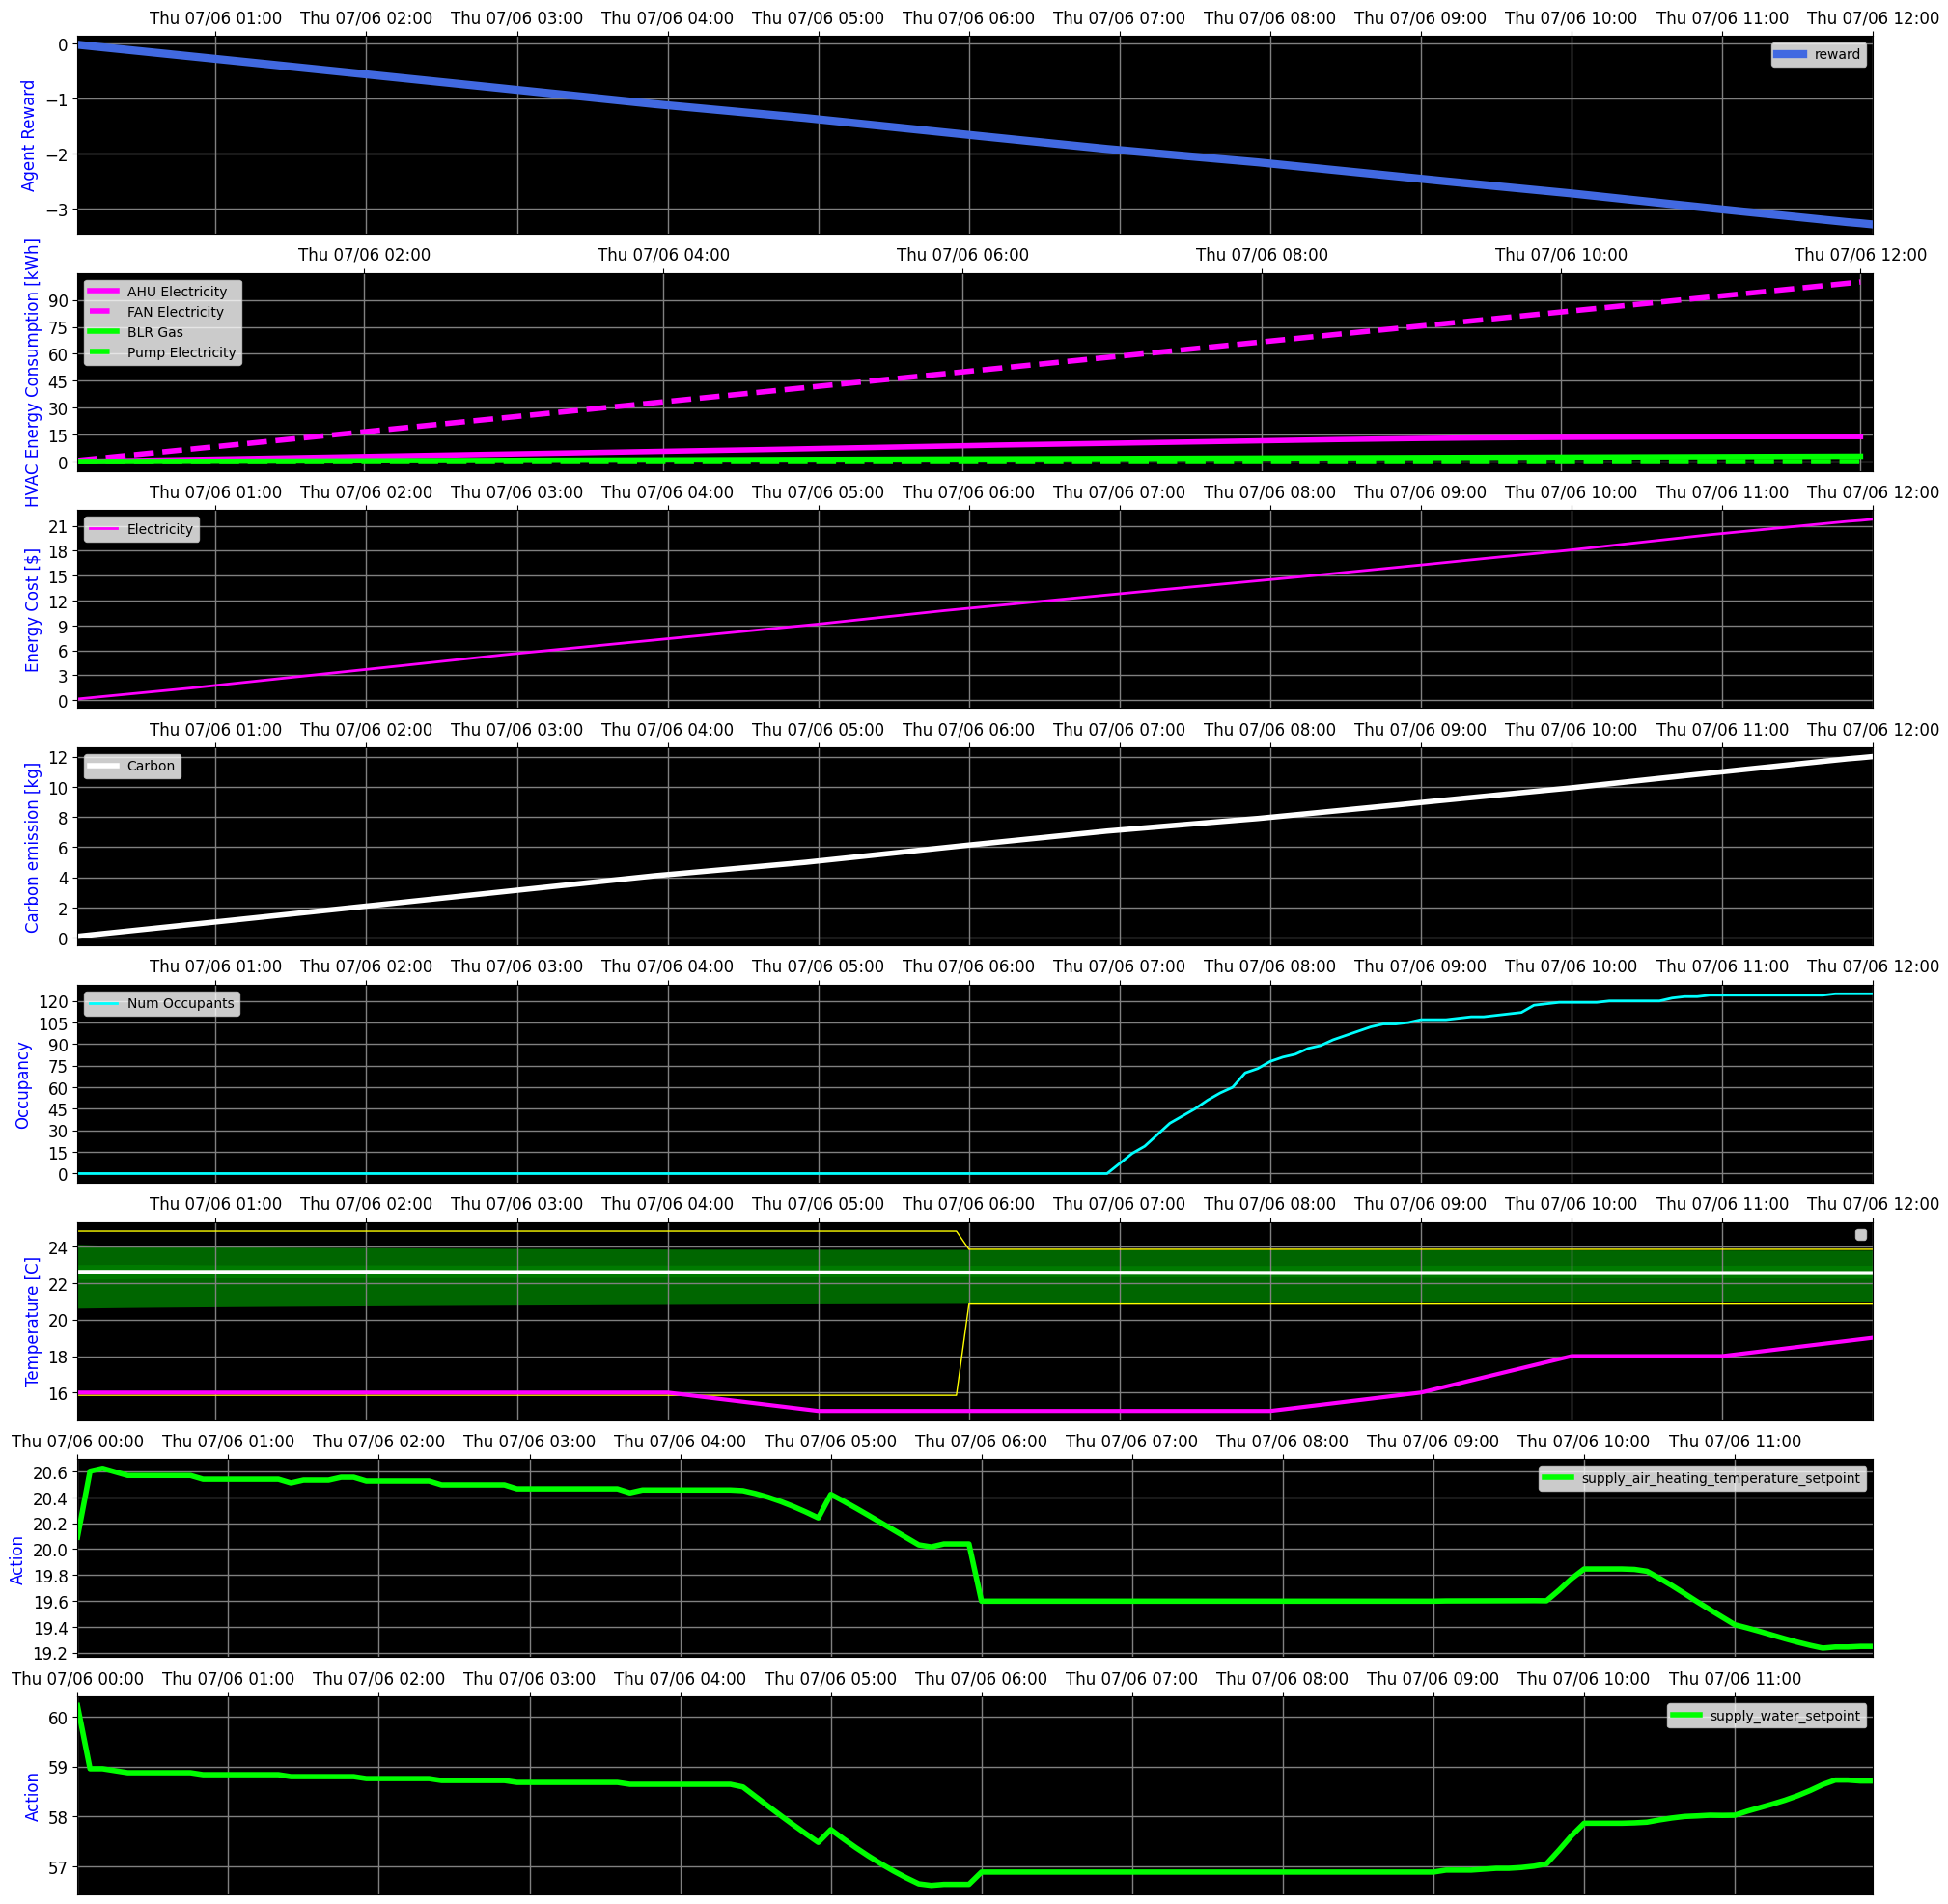

Environment 2023-07-06 19:00:00+00:00

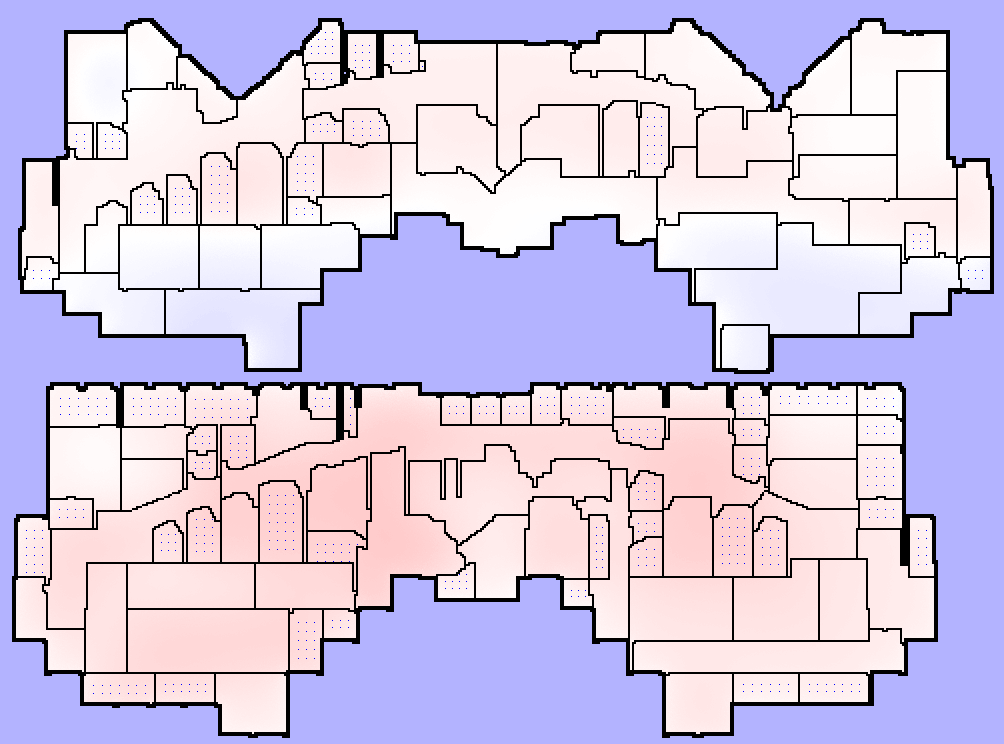

Step   145 of  4032 (  3%) Sim Time: 2023-07-06 12:05 Reward: -0.02 Cumulative Reward:    -3.30 Execution Time: 0 days 00:01:57.188570 Mean Execution Time: 0.81s  Replay Buffer Size: 142
Step   146 of  4032 (  3%) Sim Time: 2023-07-06 12:10 Reward: -0.02 Cumulative Reward:    -3.32 Execution Time: 0 days 00:01:57.944310 Mean Execution Time: 0.81s  Replay Buffer Size: 145
Step   147 of  4032 (  3%) Sim Time: 2023-07-06 12:15 Reward: -0.02 Cumulative Reward:    -3.34 Execution Time: 0 days 00:01:58.690579 Mean Execution Time: 0.81s  Replay Buffer Size: 145
Step   148 of  4032 (  3%) Sim Time: 2023-07-06 12:20 Reward: -0.02 Cumulative Reward:    -3.36 Execution Time: 0 days 00:01:59.452236 Mean Execution Time: 0.81s  Replay Buffer Size: 145
Step   149 of  4032 (  3%) Sim Time: 2023-07-06 12:25 Reward: -0.02 Cumulative Reward:    -3.38 Execution Time: 0 days 00:02:00.195716 Mean Execution Time: 0.81s  Replay Buffer Size: 148
Step   150 of  4032 (  3%) Sim Time: 2023-07-06 12:30 Reward: -0.

KeyboardInterrupt: 

In [20]:
num_training_iterations = 80 # 8 * 10 -> 10 episodes
num_gradient_updates_per_training_iteration = 100

# Collect the performance results with teh untrained model.
eval_actor.run_and_log()

logging_info('Training.')
iter = 0

time_step = collect_env.reset()  # Initial time step from the environment

for iter in range(num_training_iterations):
    print('Training iteration: ', iter)
    
    for _ in range(8):
        driver_time_step, driver_policy_state = collect_driver.run(time_step)
        
    time_step = driver_time_step
    if time_step.is_last():
        print('Episode has ended. Resetting environment.')
        time_step = collect_env.reset()

    logging_info(
        'Executing %d gradient updates.'
        %num_gradient_updates_per_training_iteration
    )
    # Now, with the additional collectsteps in the replay buffer,
    # allow the agent to make additional policy improvements.
    loss_info = agent_learner.run(
        iterations=num_gradient_updates_per_training_iteration
    )
    
    reverb_replay.py_client.clear()
    logging_info('Evaluating.')

    _ = eval_env.reset()
    # Run the eval actor after the training iteration, and get its performance.
    eval_actor.run_and_log()

rb_observer.close()
reverb_server.stop()